In [1]:
library(dplyr)
library(readr)
install.packages("caret")
library(caret)
install.packages("survminer")
library(survminer)
install.packages("survival")
library(survival)
install.packages("ggplot2")
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggplot2

Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: ggpubr

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘survival’


The following object is masked from ‘package:survminer’:

    myeloma


The following object is masked from ‘package:caret’:

    cluster


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [39]:
# Leer el archivo CSV desde la URL
url <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/machine_FOTL1.csv"
urlAge <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/machine_age.csv"
df <- read_csv(url, show_col_types = FALSE)
df_age <- read_csv(urlAge, show_col_types = FALSE)

In [40]:
summary(df)

   equipment        operation           wo_type           base_model       
 Min.   : 100268   Length:67203       Length:67203       Length:67203      
 1st Qu.:1023882   Class :character   Class :character   Class :character  
 Median :1076710   Mode  :character   Mode  :character   Mode  :character  
 Mean   :1020956                                                           
 3rd Qu.:1145736                                                           
 Max.   :1169478                                                           
 problem_code       problem_desc       failure_code       failure_desc      
 Length:67203       Length:67203       Length:67203       Length:67203      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
      

In [41]:
head(df,5)

equipment,operation,wo_type,base_model,problem_code,problem_desc,failure_code,failure_desc,cause_code,cause_desc,action_code,action_desc,mechanic,date,downtime_gross,pit_coverage,real_downtime,parts_cost,repair_hours,waiting_hours
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1105253,TOP STITCH COLLAR,Corrective Maintenance,VG2700,SEWP012,It does not cut the trim off / No corta el desperdicio,SEWF006,Electric panel failure / Falla pánel eléctrico,SEWC082,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,SEWA083,Sharpen knife / Afilar cuchillas,Edwin Froylan Turcios,6/2/2023,13.91666667,0,13.91666667,$15.00,13.91667,0.00
1033218,TUBE FLY,Corrective Maintenance,VF2403,SEWP001,It does not sew / No cose,SEWF011,Folder failure / Falla doblillador,SEWC134,Damaged folder guide / Guía de doblillador en mal estado,SEWA122,Replace folder guide / Reemplazar guía de doblillador,MAURICIO DAVILA SANCHEZ,4/27/2023,12.25000000,0,12.25000000,$0.00,12.25000,0.00
1011770,FLAT LOCK,Breakdown,FD62,SEWP002,It sews with defect / Cose con defecto,SEWF001,Machine head failure stopping sewing / Falla cabezal dejando de coser,SEWC013,Misadjusted machine head looper / Enlazador de cabezal desajustado,SEWA010,Replace machine head presser foot / Reemplazar prensatela de cabezal,FAULO VICENTE TEC TORRES,9/12/2023,0.01666667,0,0.01666667,$0.00,12.16667,-12.15
1010832,HEM SLEEVE,Corrective Maintenance,VC2713,SEWP001,It does not sew / No cose,SEWF006,Electric panel failure / Falla pánel eléctrico,SEWC071,Damaged PLC of electrical panel / PLC de panel eléctrico en mal estado,SEWA069,Replace electric panel PLC / Reemplazar PLC de panel eléctrico,DENY RAYMUNDO PUCH POOL,1/15/2023,12.00000000,0,12.00000000,$0.00,12.00000,0.00
1069897,HEM SLEEVE,Corrective Maintenance,VC2700,SEWP001,It does not sew / No cose,SEWF006,Electric panel failure / Falla pánel eléctrico,SEWC071,Damaged PLC of electrical panel / PLC de panel eléctrico en mal estado,SEWA069,Replace electric panel PLC / Reemplazar PLC de panel eléctrico,DENY RAYMUNDO PUCH POOL,7/2/2023,12.00000000,0,12.00000000,$0.00,12.00000,0.00


**ANALISIS DE VARIABLES**

In [42]:
dim(df)

[1] 67203    20

In [43]:
# Calcular la frecuencia de cada operación
operation_freq <- df %>%
  group_by(operation) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular el porcentaje acumulado
operation_freq <- operation_freq %>%
  mutate(cum_count = cumsum(count),
         cum_perc = cum_count / sum(count))

operation_freq

operation,count,cum_count,cum_perc
<chr>,<int>,<int>,<dbl>
HEM SLEEVE,12364,12364,0.1839799
HEM BOTTOM,7560,19924,0.2964749
JOIN PANEL,3958,23882,0.3553710
SET SLEEVE,3658,27540,0.4098031
TAPE SHOULDER,3484,31024,0.4616461
HEM AROUND,2579,33603,0.5000223
JOIN SHOULDER,2355,35958,0.5350654
FLAT SEAM,2252,38210,0.5685758
ATTACH ELASTIC,2236,40446,0.6018481


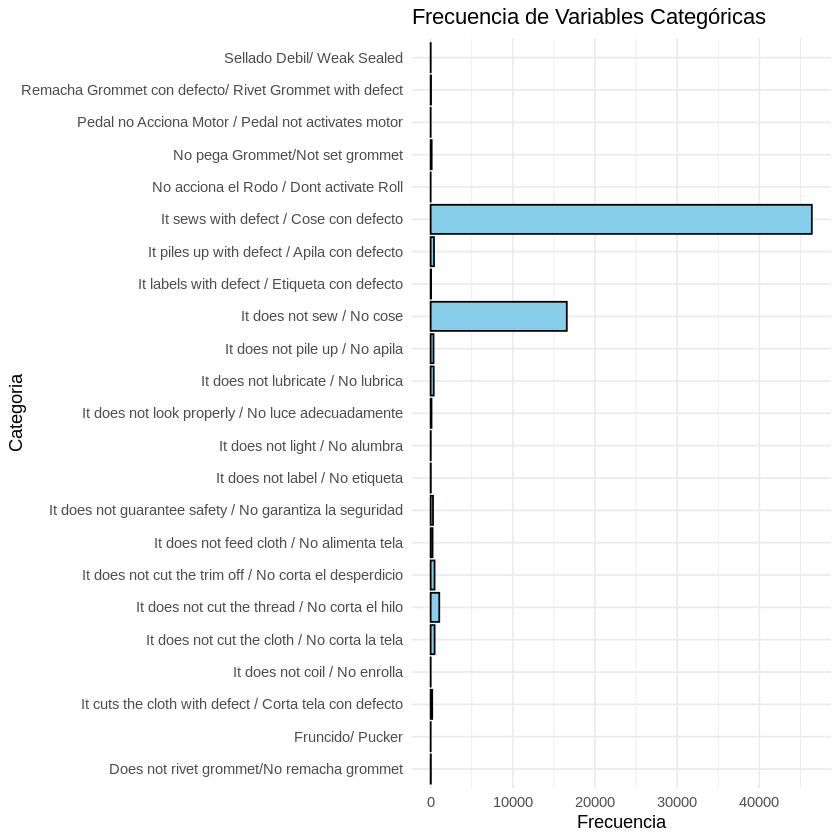

In [44]:
# Crear el gráfico de barras
ggplot(df, aes(y = problem_desc)) +
  geom_bar(fill = 'skyblue', color = 'black') +
  labs(title = 'Frecuencia de Variables Categóricas',
       x = 'Frecuencia',
       y = 'Categoria') +
  theme_minimal()

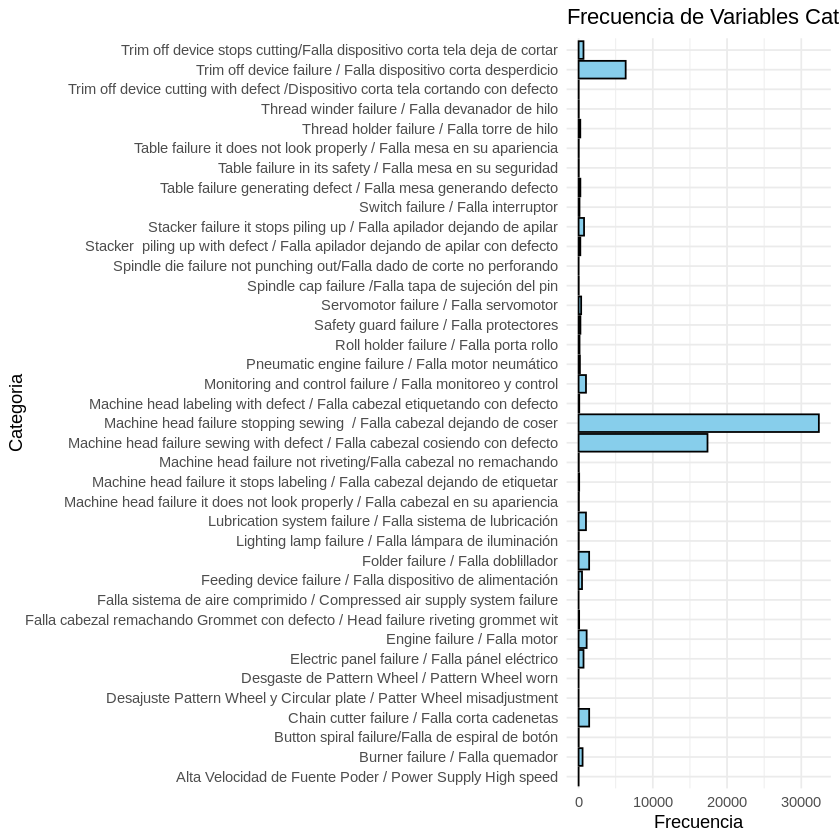

In [45]:
# Crear el gráfico de barras
ggplot(df, aes(y = failure_desc)) +
  geom_bar(fill = 'skyblue', color = 'black') +
  labs(title = 'Frecuencia de Variables Categóricas',
       x = 'Frecuencia',
       y = 'Categoria') +
  theme_minimal()

In [46]:
# Calcular la frecuencia de causas de fallo
cause_freq <- df %>%
  group_by(cause_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular el porcentaje acumulado
cause_freq <- cause_freq %>%
  mutate(cum_count = cumsum(count),
         cum_perc = cum_count / sum(count))
cause_freq

cause_desc,count,cum_count,cum_perc
<chr>,<int>,<int>,<dbl>
Misadjusted machine head looper / Enlazador de cabezal desajustado,11280,11280,0.1678496
Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,6052,17332,0.2579052
Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,5875,23207,0.3453268
Broken machine head ball joint / Rotura de biela de cabezal,4459,27666,0.4116781
Misadjusted machine head presser foot / Prensatela de cabezal desajustado,2871,30537,0.4543994
Misadjusted machine head teeth / Dientes de cabezal desajustados,2704,33241,0.4946357
Misadjusted machine head chopper / Cuchilla de cabezal desajustada,2518,35759,0.5321042
Misadjusted machine head needle bar / Barra de aguja de cabezal desajustada,1889,37648,0.5602131
Oil leak in machine head / Fuga de aceite lubricante en cabezal,1787,39435,0.5868042


In [47]:
# Calcular la frecuencia de acciones correctivas
action_freq <- df %>%
  group_by(action_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular el porcentaje acumulado
action_freq <- action_freq %>%
  mutate(cum_count = cumsum(count),
         cum_perc = cum_count / sum(count))
action_freq

action_desc,count,cum_count,cum_perc
<chr>,<int>,<int>,<dbl>
Adjust machine head looper / Ajustar enlazador de cabezal,8253,8253,0.1228070
Adjust machine head needle guard / Ajustar guarda aguja de cabezal,6073,14326,0.2131750
Sharpen knife / Afilar cuchillas,4559,18885,0.2810142
Adjust machine head teeth / Ajustar dientes de cabezal,4511,23396,0.3481392
Replace machine head ball joint / Reemplazar biela de cabezal,4470,27866,0.4146541
Replace machine head looper / Reemplazar enlazador de cabezal,3844,31710,0.4718539
Adjusted machine head presser foot / Ajustar prensatela de cabezal,3173,34883,0.5190691
Replace trim off knife / Reemplazar cuchilla de corta desperdicio,2452,37335,0.5555556
Adjust machine head knife / Ajustar cuchilla de cabezal,1933,39268,0.5843192


In [48]:
# Calcular la frecuencia de acciones correctivas
mechanic_freq <- df %>%
  group_by(mechanic) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular el porcentaje acumulado
mechanic_freq <- mechanic_freq %>%
  mutate(cum_count = cumsum(count),
         cum_perc = cum_count / sum(count))
mechanic_freq

mechanic,count,cum_count,cum_perc
<chr>,<int>,<int>,<dbl>
Jose Manuel Perez Zepeda,1507,1507,0.02242459
DIEGO CUELLAR,1473,2980,0.04434326
Erick Garcia Lima,1391,4371,0.06504174
Ronald Antonio Herrera,1370,5741,0.08542773
Omar Maldonado,1186,6927,0.10307576
Carlos Alberto Alfaro Salamanca,1185,8112,0.12070890
Immer Sanchez,1159,9271,0.13795515
Antony Ulloa,1158,10429,0.15518652
Eduardo Antonio Flores Campos,1087,11516,0.17136140


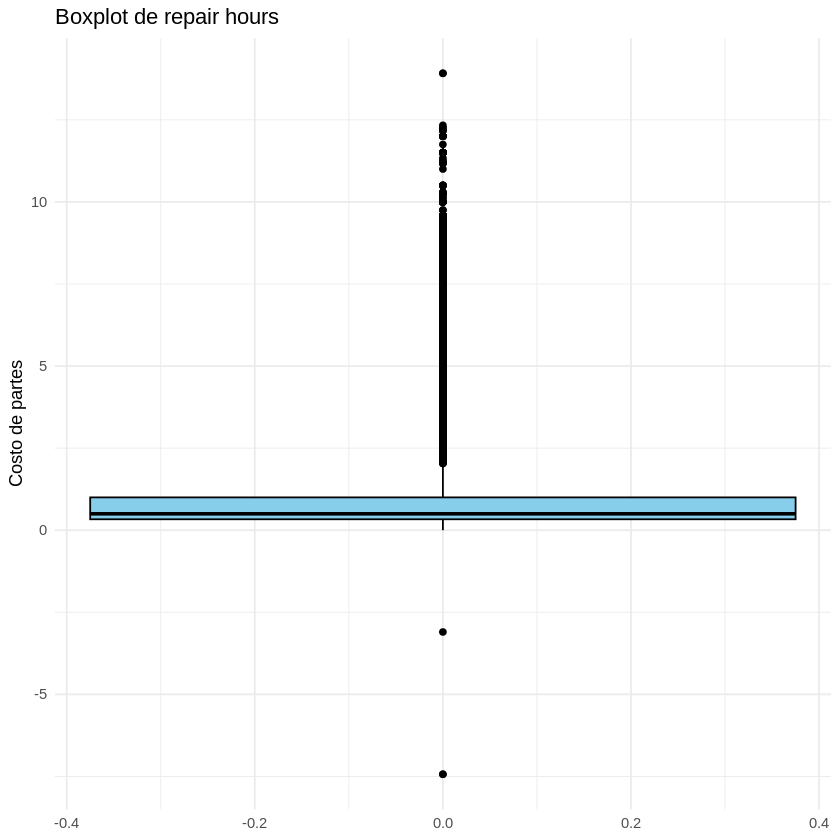

In [49]:
# Crear el boxplot de repair_hours
ggplot(df, aes(y = repair_hours)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de repair hours',
       y = 'Costo de partes') +
  theme_minimal()

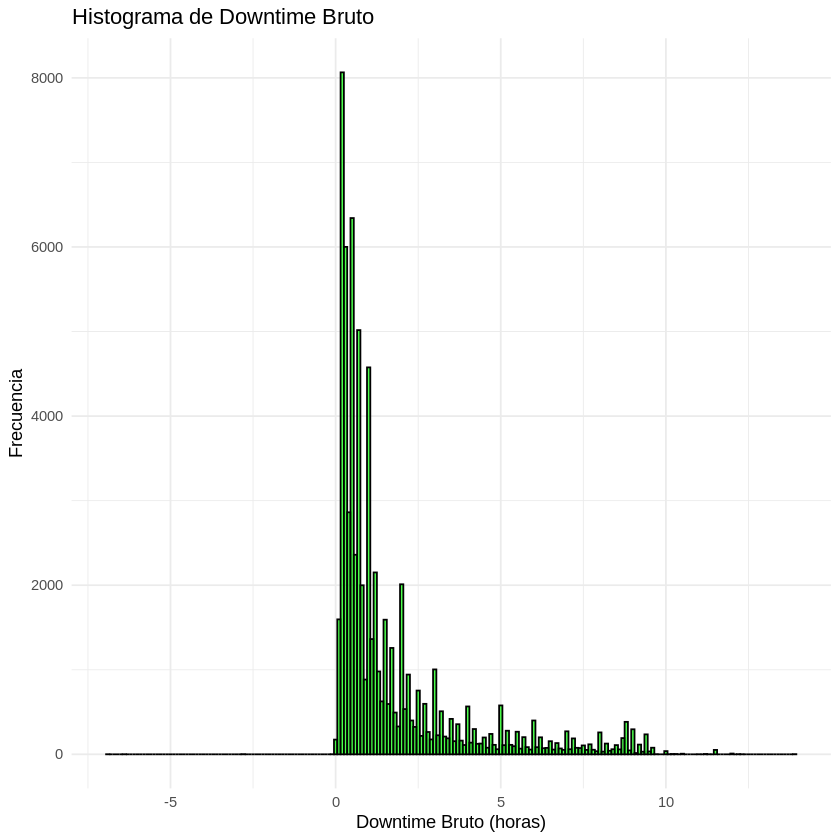

In [50]:
# Histograma de 'downtimeGross'
hist_downtimeGross <- ggplot(df, aes(x = downtime_gross)) +
  geom_histogram(binwidth = 0.1, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de Downtime Bruto",
       x = "Downtime Bruto (horas)",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_downtimeGross)

**LIMPIEZA DE DATOS**

In [51]:
sapply(df, function(x) sum(is.na(x)))

equipment      operation        wo_type     base_model   problem_code 
             0              0              0              0              0 
  problem_desc   failure_code   failure_desc     cause_code     cause_desc 
             0              0              0              0              0 
   action_code    action_desc       mechanic           date downtime_gross 
             0              0              0              0              0 
  pit_coverage  real_downtime     parts_cost   repair_hours  waiting_hours 
             0              0              0              0              0

In [52]:
# Remover el símbolo de dólar y las comas, y convertir a float
df$parts_cost <- as.numeric(gsub("[\\$,()]", "", df$parts_cost))

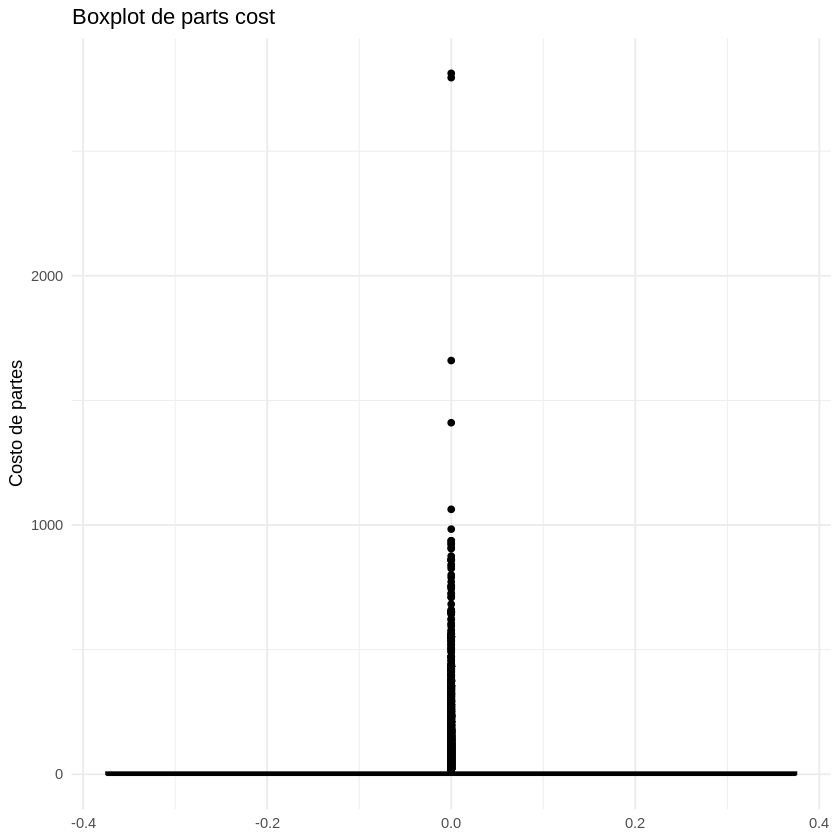

In [53]:
# Crear el boxplot de parts_cost
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo de partes') +
  theme_minimal()

In [54]:
# Convertir la columna 'Date' al formato adecuado
df$date <- as.Date(df$date, format="%m/%d/%Y")  # Ajusta el formato según tus datos
# Ordenar el DataFrame por fecha
df <- df %>%
  arrange(date)

In [55]:
mean(df$downtime_gross < 0)

[1] 7.440144e-05

In [56]:
# Filtrar registros donde downtimeGross no sea negativo
df_filtered <- df %>%
  filter(downtime_gross >= 0)

In [57]:
mean(df$repair_hours < 0)

[1] 4.464086e-05

In [58]:
# Calcular valor absoluto de repair hours
df$repair_hours <- abs(df$repair_hours)

In [59]:
#Eliminar columnas que no seran utilizadas
df <- select(df, -problem_code, -failure_code, -cause_code, -action_code, -pit_coverage, -real_downtime, -waiting_hours)

In [60]:
# Calcular la diferencia en días entre la fecha actual y la fecha del último mantenimiento preventivo registrado para cada equipo
df <- df %>%
  group_by(equipment) %>%
  mutate(Time_Since_Last_Preventive_Maintenance = ifelse(`wo_type` == "Preventative Maintenance", difftime(max(date), date, units = "days"), 0))

In [61]:
# Filtrar el DataFrame por 'WO Type' igual a 'Corrective Maintenance'
df <- df %>%
  filter(`wo_type` == "Corrective Maintenance")

In [62]:
# Calcular la diferencia en días entre fechas consecutivas
df <- df %>%
  group_by(equipment) %>%
  mutate(Days_Between_Failures = difftime(date, lag(date), units = "days"))

# Reemplazar los valores NA en Days_Between_Failures
df$Days_Between_Failures[is.na(df$Days_Between_Failures)] <- as.numeric(difftime(df$date[is.na(df$Days_Between_Failures)], as.Date("2023-01-01"), units = "days"))

In [63]:
# Convertir 'Days_Between_Failures' a numeric
df$Days_Between_Failures <- as.numeric(df$Days_Between_Failures, units = "days")

**ANALISIS DE VARIABLE OBJETIVO**

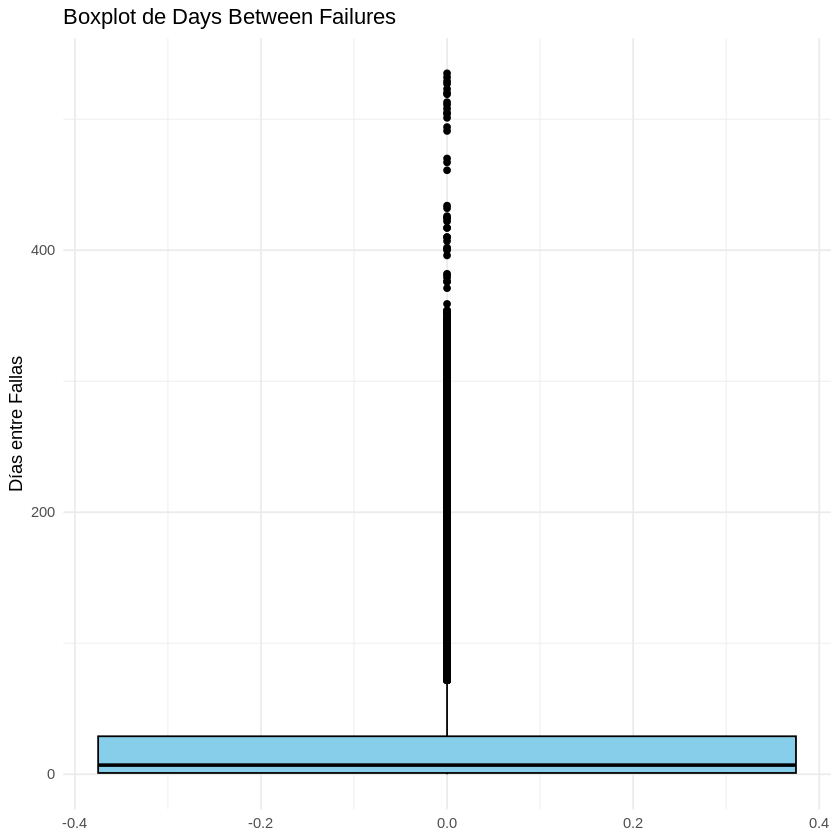

In [64]:
# Crear el boxplot de daysbetween_failures
ggplot(df, aes(y = Days_Between_Failures)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de Days Between Failures',
       y = 'Días entre Fallas') +
  theme_minimal()

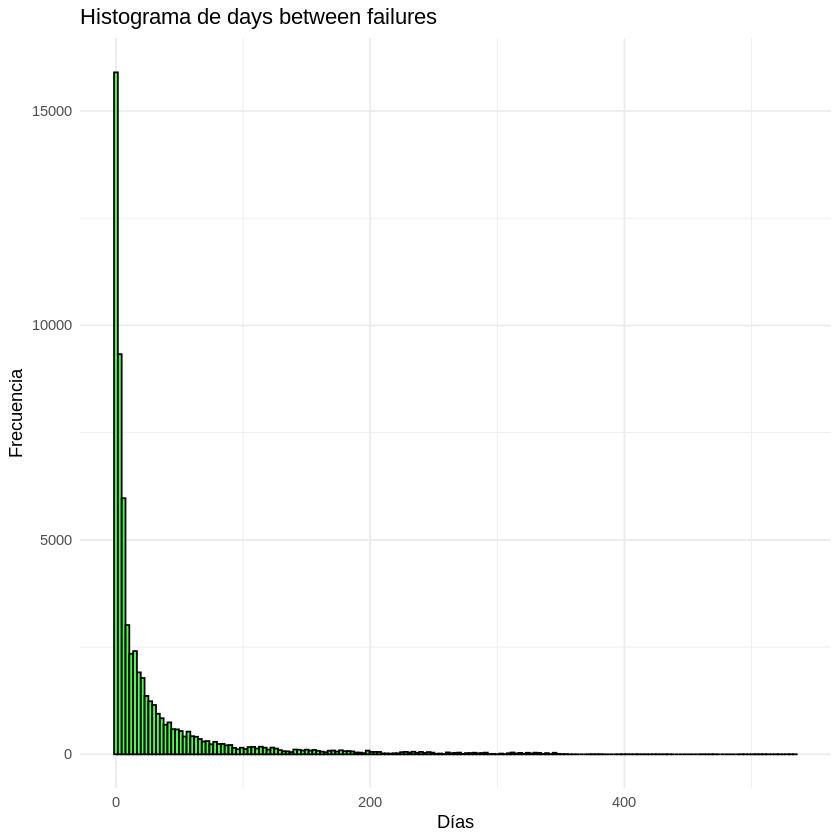

In [65]:
# Histograma de 'Days_Between_Failures'
hist_days_failures <- ggplot(df, aes(x = Days_Between_Failures)) +
  geom_histogram(binwidth = 3, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de days between failures",
       x = "Días",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_days_failures)

**MODELO DE REGRESION LINEAL INICIAL PARA PREDECIR DAYS BETWEEN FAILURES**



In [66]:
df <- select(df, -wo_type, -date)

In [67]:
# Inicializar y ajustar el modelo de regresión lineal
model1 <- lm(Days_Between_Failures~. -equipment -Time_Since_Last_Preventive_Maintenance, data = df)
# Resumen del modelo
summary(model1)


Call:
lm(formula = Days_Between_Failures ~ . - equipment - Time_Since_Last_Preventive_Maintenance, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-185.47  -20.25   -6.52    5.11  503.50 

Coefficients: (8 not defined because of singularities)
                                                                                               Estimate
(Intercept)                                                                                  -4.412e+01
operationANKLE                                                                                2.264e+01
operationATTACH BOW                                                                           1.618e+01
operationATTACH ELASTIC                                                                       1.656e+01
operationBACK NECK                                                                            1.030e+01
operationBARTACK                                                                              2.542e+01
operat

**CALCULO DE VARIABLES PARA MEJORA DEL AJUSTE**

In [68]:
#Calcular los fallos acumulativos
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Failure_Count = row_number())

In [69]:
# Calcular la mediana de tiempo de reparación
df <- df %>%
  group_by(equipment) %>%
  mutate(Median_Repair_Time = median(repair_hours, na.rm = TRUE))

In [70]:
# Calcular el costo acumulado de mantenimiento
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Maintenance_Cost = cumsum(parts_cost))

**MODELO DE REGRESION LINEAL PARA PREDECIR DAYS BETWEEN FAILURES CON MAS VARIABLES**

In [71]:
# Inicializar y ajustar el modelo de regresión lineal
model2 <- lm(Days_Between_Failures~. -equipment, data = df)
# Resumen del modelo
summary(model2)


Call:
lm(formula = Days_Between_Failures ~ . - equipment, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-184.90  -20.38   -7.20    6.58  463.92 

Coefficients: (9 not defined because of singularities)
                                                                                               Estimate
(Intercept)                                                                                  -4.156e+01
operationANKLE                                                                                2.175e+01
operationATTACH BOW                                                                           1.511e+01
operationATTACH ELASTIC                                                                       1.739e+01
operationBACK NECK                                                                            1.233e+01
operationBARTACK                                                                              2.481e+01
operationBARTACK DRAWCORD                           

In [72]:
write.csv(df, "machine data.csv", row.names = FALSE)

**MODELO AGREGANDO LA VARIABLE "MACHINE AGE"**

In [73]:
df_merged <- merge(df, df_age, by.x = "equipment", by.y = "Equipment", all = TRUE)

In [74]:
head(df_merged,5)

,equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,downtime_gross,parts_cost,repair_hours,Time_Since_Last_Preventive_Maintenance,Days_Between_Failures,Cumulative_Failure_Count,Median_Repair_Time,Cumulative_Maintenance_Cost,Age
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,100268,BIND LEG,VF2500,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head teeth / Dientes de cabezal desajustados,Adjust machine head teeth / Ajustar dientes de cabezal,Jaime Rivera,1.2500000,16.81,1.2500000,0,275,1,1.250,16.81,8
2,100312,SET ZIPPER,LT2-B872,It sews with defect / Cose con defecto,Machine head failure sewing with defect / Falla cabezal cosiendo con defecto,Damaged bobbin / Bobina en mal estado,Replace bobbin / Reemplazar bobina,JERONIMO FUNEZ,0.6666667,0.80,0.6666667,0,3,7,0.475,16.71,14
3,100312,SET ZIPPER,LT2-B872,It sews with defect / Cose con defecto,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Replace trim off knife / Reemplazar cuchilla de corta desperdicio,JERONIMO FUNEZ,0.4500000,0.00,0.4500000,0,4,5,0.475,2.67,14
4,100312,BARTACK,LT2-B872,It does not sew / No cose,Machine head failure stopping sewing / Falla cabezal dejando de coser,Broken machine head ball joint / Rotura de biela de cabezal,Replace machine head ball joint / Reemplazar biela de cabezal,JERONIMO FUNEZ,0.2500000,2.67,0.2500000,0,1,3,0.475,2.67,14
5,100312,SET ZIPPER,LT2-B872,It does not cut the cloth / No corta la tela,Trim off device stops cutting/Falla dispositivo corta tela deja de cortar,Blunt trim off knife / Cuchilla de corta tela desafilada,Replace knives / Reemplazar cuchillas,Leonardo Villanueva,1.0000000,13.24,1.0000000,0,227,6,0.475,15.91,14


In [75]:
# Inicializar y ajustar el modelo de regresión lineal
model3 <- lm(Days_Between_Failures~. -equipment, data = df_merged)
# Resumen del modelo
summary(model3)


Call:
lm(formula = Days_Between_Failures ~ . - equipment, data = df_merged)

Residuals:
    Min      1Q  Median      3Q     Max 
-184.73  -20.36   -7.20    6.57  463.82 

Coefficients: (9 not defined because of singularities)
                                                                                               Estimate
(Intercept)                                                                                  -4.109e+01
operationANKLE                                                                                2.186e+01
operationATTACH BOW                                                                           1.509e+01
operationATTACH ELASTIC                                                                       1.730e+01
operationBACK NECK                                                                            1.251e+01
operationBARTACK                                                                              2.476e+01
operationBARTACK DRAWCORD                    

**IMPLEMENTACION DE BACKWARD**

In [ ]:
# Realizar backward elimination
model_final <- step(model3, direction = "backward")
model_final$anova

In [43]:
formula = as.formula("Days_Between_Failures ~ operation + base_model + problem_desc +
    failure_desc + mechanic + downtime_gross + parts_cost + repair_hours +
    Cumulative_Failure_Count + Median_Repair_Time + Cumulative_Maintenance_Cost")

In [ ]:
# Inicializar y ajustar el modelo de regresión lineal
model4 <- lm(formula = formula, data = df)
# Resumen del modelo
summary(model4)

**ANALISIS DE SUPERVIVENCIA PARA MAQUINARIA DE RUEDO DE MANGA**

In [ ]:
# Cargar datos
url <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/maquina2.csv"
data <- read_csv(url, show_col_types = FALSE)

In [ ]:
head(data,5)

In [ ]:
# Filtrar el DataFrame por 'WO Type' igual a 'Corrective Maintenance'
data <- data %>%
  filter(`WO Type` == "Corrective Maintenance")
data <- data%>%
  filter(Operation == "HEM SLEEVE")

In [ ]:
# Convertir la columna 'Date' al formato adecuado
data$Date <- as.Date(data$Date, format="%m/%d/%Y")  # Ajusta el formato según tus datos

# Ordenar por equipo y fecha
data <- data %>% arrange(Equipment, Date)

# Calcular el tiempo entre fallas y si la falla ocurrió
data <- data %>%
  group_by(Equipment) %>%
  mutate(Previous_Failure_Date = lag(Date),
         Days_Between_Failures = as.numeric(Date - Previous_Failure_Date),
         Event_Occurred = ifelse(is.na(Previous_Failure_Date), 0, 1)) %>%
  ungroup()

# Eliminar filas con NA en 'Days_Between_Failures'
data <- data %>% filter(!is.na(Days_Between_Failures))

In [ ]:
head(data,5)

In [ ]:
# Convertir las variables categóricas a factores
data$Equipment <- as.factor(data$Equipment)
data$Operation <- as.factor(data$Operation)
data$Model.Base <- as.factor(data$`Model Base`)
data$Problem.Code <- as.factor(data$`Problem Code`)
data$Failure.Code <- as.factor(data$`Failure Code`)
data$Cause.Code <- as.factor(data$`Cause Code`)
data$Action.Code <- as.factor(data$`Action Code`)

In [ ]:
cox_model <- coxph(Surv(Days_Between_Failures, Event_Occurred) ~
                  Model.Base + Problem.Code + Failure.Code + Cause.Code +
                   Action.Code + downtimeGross + partsCost +repairHours, data = data)

In [ ]:
# Resumen del modelo
summary(cox_model)

In [ ]:
# Curvas de supervivencia ajustadas
fit <- survfit(cox_model)
ggsurvplot(fit, data = data, risk.table = TRUE, pval = TRUE,
           title = "Curvas de Supervivencia Ajustadas",
           xlab = "Tiempo (días)", ylab = "Probabilidad de Supervivencia")


In [ ]:
# Imprimir el resumen del ajuste para ver la mediana de supervivencia
summary_fit <- summary(fit)
print(summary_fit)

# Obtener la mediana de supervivencia
median_survival <- summary_fit$time[which.min(abs(summary_fit$surv - 0.5))]
print(paste("La mediana de supervivencia es:", median_survival, "días"))

In [ ]:
library(ggplot2)
library(survminer)

# Graficar la curva de supervivencia con la mediana de supervivencia resaltada
plot <- ggsurvplot(fit, data = data, risk.table = TRUE, pval = TRUE,
                   title = "Curvas de Supervivencia Ajustadas",
                   xlab = "Tiempo (días)", ylab = "Probabilidad de Supervivencia",
                   conf.int = TRUE)

# Añadir línea vertical y anotación para la mediana de supervivencia
plot$plot <- plot$plot +
  geom_vline(xintercept = median_survival, linetype = "dashed", color = "red") +
  annotate("text", x = median_survival, y = 0.5, label = paste("Mediana =", median_survival, "días"), vjust = -1, color = "red")

print(plot)